Random Pruning implemented

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import foolbox as fb
import random

tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()  # For easy reset of notebook state.

# Prune, Train Attack Pipeline

In [ ]:
pgd_success_rates = []
cw_success_rates = []
all_accuracies = []
ITERATIONS = 2
compression_rates = [1, 2, 4, 8, 16, 32, 64]
pruning_ratios = [1-1/x for x in compression_rates]
    
for j in tqdm(range(ITERATIONS)):
    accuracies = []
    pgd_success_rate = []
    cw_success_rate = []
    model = initialize_base_model(j, save_weights=True)
    for index, pruning_ratio in tqdm(enumerate(pruning_ratios)):
        model.load_weights(f'./saved-weights/base-model-weights-cnn-glob-{j}')
        for i in range(index + 1):
            if i != index:
                model.prune_globally(pruning_ratios[i])
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                              metrics=['accuracy'],
                              experimental_run_tf_function=False
                             )
                model = train_model(model, to_convergence=False)
            if i == index:
                print('final pruning and eval')
                model.prune_globally(pruning_ratios[i])
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                              metrics=['accuracy'],
                              experimental_run_tf_function=False
                             )
                model = train_model(model, to_convergence=True)
                accuracies.append(model.evaluate(x_test, y_test, verbose=0))
                pgd_success_rate.append(pgd_attack(model))
                #cw_success_rate.append(cw2_attack(model))
                
    all_accuracies.append(accuracies)
    pgd_success_rates.append(pgd_success_rate)
    cw_success_rates.append(cw_success_rate)
#write to csv and json

pd.DataFrame(all_accuracies).to_csv('saved-results/cnn-accuracies-glob-prunning.csv',index=False)
with open('saved-results/cnn-accuracies-glob-prunning.json', 'w') as f:
    json.dump(all_accuracies, f)
    
pd.DataFrame(pgd_success_rates).to_csv('saved-results/cnn-pgd-success-glob-prunning.csv',index=False)
with open('saved-results/cnn-pgd-success-glob-prunning.json', 'w') as f:
    json.dump(pgd_success_rates, f)
pd.DataFrame(cw_success_rates).to_csv('saved-results/cnn-cw-success-glob-prunning.csv',index=False)
with open('saved-results/cnn-cw-success-glob-prunning.json', 'w') as f:
    json.dump(cw_success_rates, f)

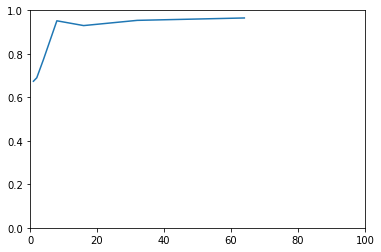

In [14]:

plt.plot(compression_rates, avg_success_rates)
plt.axis([0,100,0,1])
plt.show()

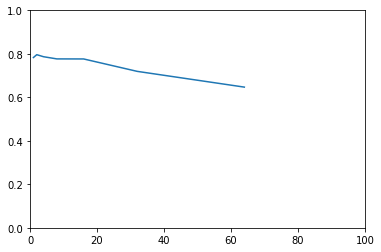

In [17]:

plt.plot(compression_rates, avg_accuracies)
plt.axis([0,100,0,1])
plt.show()

# Helper Functions

In [7]:
def initialize_base_model(index, save_weights=False):
    model = CustomConvModel()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False

                 )

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=x_train,
              y=y_train,
              batch_size=64,
              epochs=1,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )
    if save_weights == True:
        model.save_weights(f'./saved-weights/base-model-weights-cnn-glob-{index}')
    return model



def train_model(model, to_convergence=True):
    if to_convergence == True:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=100,
            callbacks=[callback],
            validation_data=(x_test, y_test),
            )
    if to_convergence == False:
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=5,
            validation_data=(x_test, y_test),
            )
    return model

def prune_weights(model, pruning_ratio):
    weights = model.get_weights()
    weights_to_prune = model.get_weights()
    for index, weight in enumerate(weights):
        
        if (index == 9) or (index == 12) :
            #print(weight.shape)
            #print(index)
            flat_weights = weight.flatten()
            flat_weights_to_prune = weights_to_prune[index+2].flatten()
            #print (flat_weights_to_prune.shape, flat_weights.shape)
            flat_weights_df = pd.DataFrame(flat_weights)
            flat_weights_to_prune_df = pd.DataFrame(flat_weights_to_prune)
            no_of_weights_to_prune = int(len(flat_weights)*pruning_ratio)
            #print(len(flat_weights))
            #print('no of weights',no_of_weights_to_prune)
            #print('weights to prune shape', flat_weights_to_prune.shape)
            indices_to_delete = flat_weights_df.abs().values.argsort(0)[:no_of_weights_to_prune]
            for idx_to_delete in indices_to_delete:
                flat_weights_to_prune[idx_to_delete] = 0
            dims = weights_to_prune[index+2].shape
            weights_reshaped = flat_weights_to_prune.reshape(dims)
            weights_to_prune[index+2] = weights_reshaped
    #print(weights_to_prune)
    return weights_to_prune

def pgd_attack(model_to_attack):
    fmodel = fb.models.TensorFlowModel(model_to_attack, bounds=(0,1))
    attack = fb.attacks.LinfProjectedGradientDescentAttack()
    adversarials = attack(
        fmodel,
        x,
        y,
        epsilons=[25/255]
    )
    return np.count_nonzero(adversarials[2])/500

def cw2_attack(model_to_attack):
    fmodel = fb.models.TensorFlowModel(model_to_attack, bounds=(0,1))
    attack = fb.attacks.L2CarliniWagnerAttack()
    adversarials = attack(
        fmodel,
        x,
        y,
        #epsilons=[.5]
        epsilons=None
    )
    return np.count_nonzero(adversarials[2])/len(y)

def prune_conv_layers(pruning_ratio):
    layer_to_prune = [0, 3]
    pruned_weights = model.get_weights()
    
    for layer in layer_to_prune:
        converted_weights = convert_from_hwio_to_iohw(model.get_weights()[layer])
        converted_mask = convert_from_hwio_to_iohw(model.get_weights()[layer + 2]).numpy()
        for input_index, input_layer in enumerate(converted_weights):

            for kernel_index, kernel in enumerate(input_layer):
                dims = kernel.shape
                flat_weights = kernel.numpy().flatten()
                flat_masks = converted_mask[input_index][kernel_index].flatten()
                flat_weights_df = pd.DataFrame(flat_weights)
                flat_mask_df = pd.DataFrame(flat_masks)
                no_of_weights_to_prune = int(len(flat_weights)*pruning_ratio)
                #print(no_of_weights_to_prune)
                indices_to_delete = flat_weights_df.abs().values.argsort(0)[:no_of_weights_to_prune]
                for idx_to_delete in indices_to_delete:
                    flat_masks[idx_to_delete] = 0

                converted_mask[input_index][kernel_index] = flat_masks.reshape(dims)
        back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
        pruned_weights[layer+2] = back_converted_mask
    
    return pruned_weights

def convert_from_hwio_to_iohw(weights_nchw):
    return tf.transpose(weights_nchw, [2, 3, 0, 1])



def convert_from_iohw_to_hwio(weights_nhwc):
    return tf.transpose(weights_nhwc, [2, 3, 0, 1])


def get_average_accuracies(all_accuracies):
    acc_per_pruning_rate=[]
    for i in range(len(all_accuracies)):
        for j in range(len(all_accuracies[i])):

            try:
                acc_per_pruning_rate[j].append(all_accuracies[i][j][1])
            except:
                acc_per_pruning_rate.append([])
                acc_per_pruning_rate[j].append(all_accuracies[i][j][1])
    avg_acc_per_pruning_rate = [sum(x)/len(x) for x in acc_per_pruning_rate]; avg_acc_per_pruning_rate
    return avg_acc_per_pruning_rate

def get_average_success_rates(all_success_rates):
    success_per_pruning_rate=[]
    for i in range(len(all_success_rates)):
        for j in range(len(all_success_rates[i])):

            try:
                success_per_pruning_rate[j].append(all_success_rates[i][j])
            except:
                success_per_pruning_rate.append([])
                success_per_pruning_rate[j].append(all_success_rates[i][j])
    avg_success_per_pruning_rate = [sum(x)/len(x) for x in success_per_pruning_rate];avg_success_per_pruning_rate
    return avg_success_per_pruning_rate

# Load Data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

x = tf.convert_to_tensor(x_train[:500].reshape(500,28*28))
y = tf.convert_to_tensor([y_train[:500]])[0];

# Define Model

In [33]:
weights = {
    # 5x5 conv, 1 input, 6 outputs
    'weights_conv_1': tf.Variable(tf.random.normal([5, 5, 1, 6])),
    # 5x5 conv, 6 inputs, 16 outputs
    'weights_conv_2': tf.Variable(tf.random.normal([5, 5, 6, 16])),
    #5x5 conv as in paper, 16 inputs, 120 outputs
    'weights_conv_3': tf.Variable(tf.random.normal([1, 1, 16, 120])),
    # fully connected, 5*5*16 inputs, 120 outputs
    'weights_dense_1': tf.Variable(tf.random.normal([5*5*16, 120])),
    # fully connected, 120 inputs, 84 outputs
    'weights_dense_2': tf.Variable(tf.random.normal([120, 84])),
    # 84 inputs, 10 outputs (class prediction)
    'weights_dense_3': tf.Variable(tf.random.normal([84, 10])),
}

masks = {
    # 5x5 conv, 1 input, 6 outputs
    'mask_conv_1': tf.Variable(tf.ones([5, 5, 1, 6]), trainable=False),
    # 5x5 conv, 6 inputs, 16 outputs
    'mask_conv_2': tf.Variable(tf.ones([5, 5, 6, 16]), trainable=False),
    #5x5 conv as in paper, 16 inputs, 120 outputs
    'mask_conv_3': tf.Variable(tf.ones([1, 1, 16, 120]), trainable=False),
    # fully connected, 5*5*16 inputs, 120 outputs
    'mask_dense_1': tf.Variable(tf.ones([5*5*16, 120]), trainable=False),
    # fully connected, 120 inputs, 84 outputs
    'mask_dense_2': tf.Variable(tf.ones([120, 84]), trainable=False),
    # 84 inputs, 10 outputs (class prediction)
    'mask_dense_3': tf.Variable(tf.ones([84, 10]), trainable=False),
}

biases = {
    #output depth
    'bias_conv_1': tf.Variable(tf.random.normal([6])),
    'bias_conv_2': tf.Variable(tf.random.normal([16])),
    'bias_dense_1': tf.Variable(tf.random.normal([120])),
    'bias_dense_2': tf.Variable(tf.random.normal([84])),
    'bias_dense_3': tf.Variable(tf.random.normal([10])),
}

#conv2D with bias and relu activation

class CustomConvLayer(layers.Layer):

    def __init__(self, weights, mask, biases, strides, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = weights
        self.m = mask
        self.b = biases
        self.s = strides
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, tf.multiply(self.w, self.m), strides=[1, self.s, self.s, 1], padding=self.p,)# data_format='NCHW')
        x = tf.nn.bias_add(x, self.b,)# 'NC...')
        return tf.nn.tanh(x)
        

#Average Pooling Layer
class CustomPoolLayer(layers.Layer):
    
    def __init__(self, k=2, padding='valid'):#padding='VALID'):
        super(CustomPoolLayer, self).__init__()
        self.k = k
        self.p = padding
    
    def call(self, inputs):
#        return tf.keras.layers.AveragePooling2D(pool_size=(self.k, self.k), strides=None, padding=self.p, data_format='channels_first')(inputs)
        return tf.nn.avg_pool2d(inputs, ksize=[1, self.k, self.k,1], strides=[1, self.k, self.k, 1], padding=self.p,)# data_format='NCHW')
    
#Dense Layer with Bias
class CustomDenseLayer(layers.Layer):
    
    def __init__(self, weights, mask, bias, activation = 'tanh'):
        super(CustomDenseLayer, self).__init__()
        self.w = weights
        self.b = bias
        self.a = activation
        self.m = mask
        
    def call(self, inputs):
        x = tf.matmul(inputs, tf.multiply(self.w, self.m))
        x = tf.nn.bias_add(x, self.b)
        if self.a == 'tanh':
            return tf.nn.tanh(x)
        if self.a == 'softmax':
            return tf.nn.softmax(x)
        
class CustomConvModel(tf.keras.Model):
    def __init__(self):
        super(CustomConvModel, self).__init__()
        self.conv1 = CustomConvLayer(weights['weights_conv_1'], masks['mask_conv_1'], biases['bias_conv_1'], 1, 'SAME')#'VALID')
        self.maxpool1 = CustomPoolLayer(k=2, padding='SAME')
        self.conv2 = CustomConvLayer(weights['weights_conv_2'], masks['mask_conv_2'], biases['bias_conv_2'], 1, 'VALID')
        self.maxpool2 = CustomPoolLayer(k=2, padding='VALID')
        #self.conv3 = CustomConvLayer(weights['weights_conv_3'], masks['mask_conv_3'], biases['bias_dense_1'], 1, 'VALID')
        self.dense1 = CustomDenseLayer(weights['weights_dense_1'], masks['mask_dense_1'], biases['bias_dense_1'], 'tanh')
        self.dense2 = CustomDenseLayer(weights['weights_dense_2'], masks['mask_dense_2'], biases['bias_dense_2'], 'tanh')
        self.dense3 = CustomDenseLayer(weights['weights_dense_3'], masks['mask_dense_3'], biases['bias_dense_3'], 'softmax')
        
    def call(self, inputs):
        x = tf.reshape(inputs, shape=[-1,28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = layers.Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x =  self.dense3(x)
        return x
    
    def prune_randomly(self, ratio):
        def prune_conv_layers_locally(self, ratio):
            conv_layer_to_prune = [0, 3]
            weights = model.get_weights()
            for layer in conv_layer_to_prune:
                converted_weights = convert_from_hwio_to_iohw(weights[layer]).numpy()
                converted_mask = convert_from_hwio_to_iohw(weights[layer + 2]).numpy()
                for input_index, input_layer in enumerate(converted_weights):
                    for kernel_index, kernel in enumerate(input_layer):
                        shape = kernel.shape
                        flat_weights = kernel.flatten()
                        flat_masks = converted_mask[input_index][kernel_index].flatten()
                        
                        no_of_weighs_to_prune = ratio * len(flat_weights)
                        # find unpruned weights
                        non_zero_weights = np.nonzero(flat_masks)[0]
                        # calculate the amount of weights to be pruned this round
                        no_of_weights_to_prune_left = int(no_of_weighs_to_prune - (len(flat_weights) - len(non_zero_weights)) )
                        # shuffle all non-zero weights
                        random.shuffle(non_zero_weights)
                        # and take the indices of the first x weights where x is the number of weights to be pruned this round
                        indices_to_delete = non_zero_weights[:no_of_weights_to_prune_left]
                        
                        for idx_to_delete in indices_to_delete:
                            flat_masks[idx_to_delete] = 0
                            flat_weights[idx_to_delete] = 0
                        converted_mask[input_index][kernel_index] = flat_masks.reshape(shape)
                        converted_weights[input_index][kernel_index] = flat_weights.reshape(shape)
                back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
                back_converted_weights = convert_from_iohw_to_hwio(converted_weights)
                weights[layer] = back_converted_weights
                weights[layer+2] = back_converted_mask
            self.set_weights(weights)
            return True
        
        def prune_dense_layers_locally(self, ratio):
            dense_layer_to_prune = [6, 9, 12]
            weights = model.get_weights()
            for index, weight in enumerate(weights):
                if index in dense_layer_to_prune:
                    shape = weight.shape
                    flat_weights = weight.flatten()
                    flat_mask = weights[index+2].flatten()
                    no_of_weighs_to_prune = ratio * len(flat_weights)
                    # find unpruned weights
                    non_zero_weights = np.nonzero(flat_mask)[0]
                    # calculate the amount of weights to be pruned this round
                    no_of_weights_to_prune_left = int(no_of_weighs_to_prune - (len(flat_weights) - len(non_zero_weights)) )
                    # shuffle all non-zero weights
                    random.shuffle(non_zero_weights)
                    # and take the indices of the first x weights where x is the number of weights to be pruned this round
                    indices_to_delete = non_zero_weights[:no_of_weights_to_prune_left]
                    for idx_to_delete in indices_to_delete:
                        flat_mask[idx_to_delete] = 0
                        flat_weights[idx_to_delete] = 0

                    mask_reshaped = flat_mask.reshape(shape)
                    weights_reshaped = flat_weights.reshape(shape)
                    weights[index+2] = mask_reshaped
                    weights[index] = weights_reshaped
            self.set_weights(weights)
            return True
        prune_conv_layers_locally(self, ratio)
        prune_dense_layers_locally(self,ratio)
    
    def prune_globally(self, ratio):
        #flat out all weights:
        conv_layer_to_prune = [0, 3]
        dense_layer_to_prune = [6, 9, 12]
        weights = self.get_weights()
        flat_weights = []
        flat_mask = []
        for x in conv_layer_to_prune + dense_layer_to_prune:
            flat_weights = np.append(flat_weights, weights[x])
            flat_mask = np.append(flat_mask, weights[x+2])
            
        no_of_weights_to_prune = int(len(flat_weights)*ratio)
        indices_to_delete = np.abs(flat_weights).argsort(0)[:no_of_weights_to_prune]
        
        for idx_to_delete in indices_to_delete:
            flat_mask[idx_to_delete] = 0
            flat_weights[idx_to_delete] = 0
        z = 0
        for x in conv_layer_to_prune + dense_layer_to_prune:
            weights[x] = flat_weights[z:z + np.prod(weights[x].shape)].reshape(weights[x].shape)
            weights[x + 2] = flat_mask[z:z + np.prod(weights[x].shape)].reshape(weights[x].shape)
            z = z + np.prod(weights[x].shape)            
        self.set_weights(weights)
        
        
            
        
        
    
    def prune_locally(self, ratio):
        def prune_conv_layers_locally(self, ratio):
            conv_layer_to_prune = [0, 3]
            weights = model.get_weights()
            for layer in conv_layer_to_prune:
                converted_weights = convert_from_hwio_to_iohw(weights[layer]).numpy()
                converted_mask = convert_from_hwio_to_iohw(weights[layer + 2]).numpy()
                for input_index, input_layer in enumerate(converted_weights):
                    for kernel_index, kernel in enumerate(input_layer):
                        shape = kernel.shape
                        flat_weights = kernel.flatten()
                        flat_masks = converted_mask[input_index][kernel_index].flatten()
                        #flat_weights_df = pd.DataFrame(flat_weights)
                        #flat_mask_df = pd.DataFrame(flat_masks)
                        no_of_weights_to_prune = int(len(flat_weights)*ratio)
                        #print(no_of_weights_to_prune)
                        #indices_to_delete = flat_weights_df.abs().values.argsort(0)[:no_of_weights_to_prune]
                        indices_to_delete = np.abs(flat_weights).argsort(0)[:no_of_weights_to_prune]


                        for idx_to_delete in indices_to_delete:
                            flat_masks[idx_to_delete] = 0
                            flat_weights[idx_to_delete] = 0

                        converted_mask[input_index][kernel_index] = flat_masks.reshape(shape)
                        converted_weights[input_index][kernel_index] = flat_weights.reshape(shape)
                back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
                back_converted_weights = convert_from_iohw_to_hwio(converted_weights)
                weights[layer] = back_converted_weights
                weights[layer+2] = back_converted_mask
            self.set_weights(weights)
            return True
        
        def prune_dense_layers_locally(self, ratio):
            dense_layer_to_prune = [6, 9, 12]
            weights = model.get_weights()
            for index, weight in enumerate(weights):
                if index in dense_layer_to_prune:
                    shape = weight.shape
                    flat_weights = weight.flatten()
                    flat_mask = weights[index+2].flatten()

                    no_of_weights_to_prune = int(len(flat_weights)*ratio)
                    indices_to_delete = np.abs(flat_weights).argsort()[:no_of_weights_to_prune]
                    for idx_to_delete in indices_to_delete:
                        flat_mask[idx_to_delete] = 0
                        flat_weights[idx_to_delete] = 0

                    mask_reshaped = flat_mask.reshape(shape)
                    weights_reshaped = flat_weights.reshape(shape)
                    weights[index+2] = mask_reshaped
                    weights[index] = weights_reshaped
            self.set_weights(weights)
            return True
        prune_conv_layers_locally(self,ratio)
        prune_dense_layers_locally(self,ratio)
            
        


# Compile and Train Model

In [34]:
model = CustomConvModel()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
              metrics=['accuracy'],
              experimental_run_tf_function=False
              
             )

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x=x_train[:500],
          y=y_train[:500],
          batch_size=128,
          epochs=1,
          callbacks=[callback],
          validation_data=(x_test, y_test),
         )
#model.save('./saved-models/mini-pipeline-CNN-baseline-model')

4/4 [==============================] - 1s 291ms/step - loss: 2.3692 - accuracy: 0.0840 - val_loss: 2.3462 - val_accuracy: 0.1057


In [197]:
model = tf.keras.models.load_model('./saved-models/mini-pipeline-CNN-baseline-model')

In [6]:
def pgd_attack(model_to_attack):
    fmodel = fb.models.TensorFlowModel(model_to_attack, bounds=(0,1))
    attack = fb.attacks.LinfProjectedGradientDescentAttack()
    adversarials = attack(
        fmodel,
        x,
        y,
        epsilons=[25/255]
    )
    return np.count_nonzero(adversarials[2])/500

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


0.996